# Memo

* Install kaggle-cli, set competition `kg -c 'compname'` and download dataset `kg download`
* move all `cat*` to `cats/`, same for dogs
* take 1000 random pictures and move them to valid/cats/ with `shuf -n 1000 -e train/cat* | xargs -i mv {} valid/cats/`, same for dogs
Furthermore use
* `ls /train/cats/ | wc -l` to count files in `/train/cats/`
* `ls /train/cats/ | grep -v 'cat'` to find all files that DON'T have cat in it. `-v`-flag inverts search.
* use: `mv /train/cat* /valid/cats` and `cp` to do the rest
* copy utils etc: `cp -t ~/fastai/ vgg16.py vgg16bn.py utils.py resnet50.py`

* sending files over scp:
`scp -i ~/.ssh/aws-key-fast-ai.pem ./zip.zip ubuntu@ec2

# Action plan
1. Initiate
2. Create train subdirectories and order images in labeled directories
3. Create valid and sample directories
4. Finetune and train model
5. Generate predictions

## 1. Initiate

In [18]:
# Import modules
import csv
import shutil
import glob
import os, sys
import numpy as np
import math
from keras.preprocessing import image
from keras.layers.core import Flatten, Dense, Dropout, Lambda

# Set directories
current_dir = os.getcwd()
sys.path.insert(1, os.path.join(sys.path[0], '..'))
LESSON_HOME_DIR = os.path.abspath(current_dir)
DATA_HOME_DIR = os.path.abspath(current_dir+'/data/invasiveplants')
results_path=DATA_HOME_DIR + '/results/'

Using Theano backend.
WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: Unable to get the number of gpus available: no CUDA-capable device is detected)


## 2. create train subdirectories

In [2]:
# Remove all folders created by this script (not test/ and backup/)
%rm -r $DATA_HOME_DIR/results/
%rm -r $DATA_HOME_DIR/valid/
%rm -r $DATA_HOME_DIR/sample/
%rm -r $DATA_HOME_DIR/train/

rm: cannot remove '/home/ubuntu/fastai/data/invasiveplants/results/': No such file or directory
rm: cannot remove '/home/ubuntu/fastai/data/invasiveplants/valid/': No such file or directory
rm: cannot remove '/home/ubuntu/fastai/data/invasiveplants/sample/': No such file or directory
rm: cannot remove '/home/ubuntu/fastai/data/invasiveplants/train/': No such file or directory


In [3]:
# Create directories
%mkdir -p $DATA_HOME_DIR/train/invasive/
%mkdir -p $DATA_HOME_DIR/train/non_invasive/
%mkdir -p $DATA_HOME_DIR/results

In [4]:
def list_pictures_by_label(csvfile):
    plantfile = []
    both = []
    labels = []
    with open(DATA_HOME_DIR+'/'+csvfile+'.csv', 'rb') as f:
        train_labels = csv.reader(f, delimiter=' ')
        temp = next(train_labels)
        for row in train_labels:
            both.append(row)
            plantfile.append(int(row[0][:-2]))
            labels.append(int(row[0][-1:]))
    invasive = [str(plantfile[i])+'.jpg' for i,x in enumerate(labels) if x==1]
    non_invasive = [str(plantfile[i])+'.jpg' for i,x in enumerate(labels) if x==0]
    return invasive, non_invasive

def copy_files_from_train_to_trainlabel(invasive, non_invasive):
    for i in range(len(invasive)):
        shutil.move(DATA_HOME_DIR+'/backup/train_unordered/'+invasive[i], DATA_HOME_DIR+'/train/invasive/')
    for j in range(len(non_invasive)):
        shutil.move(DATA_HOME_DIR+'/backup/train_unordered/'+non_invasive[j], DATA_HOME_DIR+'/train/non_invasive/')

In [5]:
copy_files_from_train_to_trainlabel(*list_pictures_by_label('train_labels'))

## 3. Create valid and sample directories

In [6]:
# Create directories
%mkdir -p $DATA_HOME_DIR/valid/invasive
%mkdir -p $DATA_HOME_DIR/valid/non_invasive
%mkdir -p $DATA_HOME_DIR/results

In [7]:
def move_from_train_to_valid():
    dirs = os.listdir(DATA_HOME_DIR+'/train')
    print(dirs)
    for iterator in dirs:
        if os.listdir(DATA_HOME_DIR+'/valid/'+iterator+'/') == []:
            g = glob.glob(DATA_HOME_DIR+'/train/'+iterator+'/'+'*.jpg')
            shuf = np.random.permutation(g)
            for i in range(int(math.ceil(0.08*len(g)))):
#                 print(DATA_HOME_DIR+'/valid/'+iterator+'/'+ os.path.basename(shuf[i]))
                shutil.move(shuf[i], DATA_HOME_DIR+'/valid/'+iterator+'/'+ os.path.basename(shuf[i]))
        else:
            print('/valid/'+ str(iterator)+ 'folder not empty')

In [8]:
move_from_train_to_valid()

['non_invasive', 'invasive']


In [9]:
# Create directories
%mkdir -p $DATA_HOME_DIR/sample/results/
%mkdir -p $DATA_HOME_DIR/sample/valid/invasive
%mkdir -p $DATA_HOME_DIR/sample/valid/non_invasive
%mkdir -p $DATA_HOME_DIR/sample/train/invasive/
%mkdir -p $DATA_HOME_DIR/sample/train/non_invasive/
%mkdir -p $DATA_HOME_DIR/sample/test/unknown

In [13]:
def create_samplefolder():
    dirs = os.listdir(DATA_HOME_DIR+'/train')
    if os.listdir(DATA_HOME_DIR+'/sample/train/'+dirs[0]+'/') == []:
        for iterator in dirs:
            g = glob.glob(DATA_HOME_DIR+'/train/'+iterator+'/'+'*.jpg')
            shuf = np.random.permutation(g)
            for i in range(20):
                shutil.copyfile(shuf[i], DATA_HOME_DIR+'/sample/train/'+iterator+'/'+ os.path.basename(shuf[i]))
            for i in range(10):
                shutil.copyfile(shuf[i], DATA_HOME_DIR+'/sample/valid/'+iterator+'/'+ os.path.basename(shuf[i]))
    else:
        print('/sample/train/ or /sample/valid/ folder not empty')
    if os.listdir(DATA_HOME_DIR+'/sample/test/unknown/') == []:
        g = glob.glob(DATA_HOME_DIR+'/test/unknown/'+'*.jpg')
        shuf = np.random.permutation(g)
        print(len(shuf))
        for i in range(10):
                    shutil.copyfile(shuf[i], DATA_HOME_DIR+'/sample/test/unknown/'+ os.path.basename(shuf[i]))
    else:
        print('/sample/test/unkwon/ folder not empty')

In [15]:
create_samplefolder()

/sample/train/ or /sample/valid/ folder not empty
1531


## 4. Finetune and train model

In [19]:
path = DATA_HOME_DIR + '/sample/'
# path = DATA_HOME_DIR

In [24]:
batch_size = 64
nb_epoch = 1

In [21]:
import vgg16stijn; reload(vgg16stijn)
from vgg16stijn import Vgg16Stijn
vgg = Vgg16Stijn()

In [25]:
batches = vgg.batch_iterator(path+'/train', batch_size=batch_size)
val_batches = vgg.batch_iterator(path+'/valid', batch_size=batch_size*2)
# test_batches = vgg.batch_iterator(path+'/test', batch_size=batch_size)

vgg.finetune_to_classes(batches)
print('finetune done')
vgg.model.optimizer.lr = 0.01
vgg.fit_n_save(batches, val_batches, nb_epoch, results_path)

Found 40 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
finetune done
Running epoch: 0
Epoch 1/1
40/40 [==============================] - 24s - loss: 1.0048 - acc: 0.5500 - val_loss: 2.0896 - val_acc: 0.7500
fit done
Completed 1 fit operations
ft0.h5


## 5. Generate predictions

In [26]:
vgg.model.load_weights(results_path+'ft3.h5')

In [27]:
batches, preds = vgg.test(path+'/test', batch_size = batch_size*2)

Found 10 images belonging to 1 classes.


[[  1.00000000e+00   2.37814501e-09]
 [  4.97364927e-05   9.99950290e-01]
 [  2.29382507e-12   1.00000000e+00]
 [  4.99140561e-01   5.00859439e-01]
 [  8.94472107e-10   1.00000000e+00]]
['unknown/155.jpg', 'unknown/1291.jpg', 'unknown/1145.jpg', 'unknown/310.jpg', 'unknown/1147.jpg']


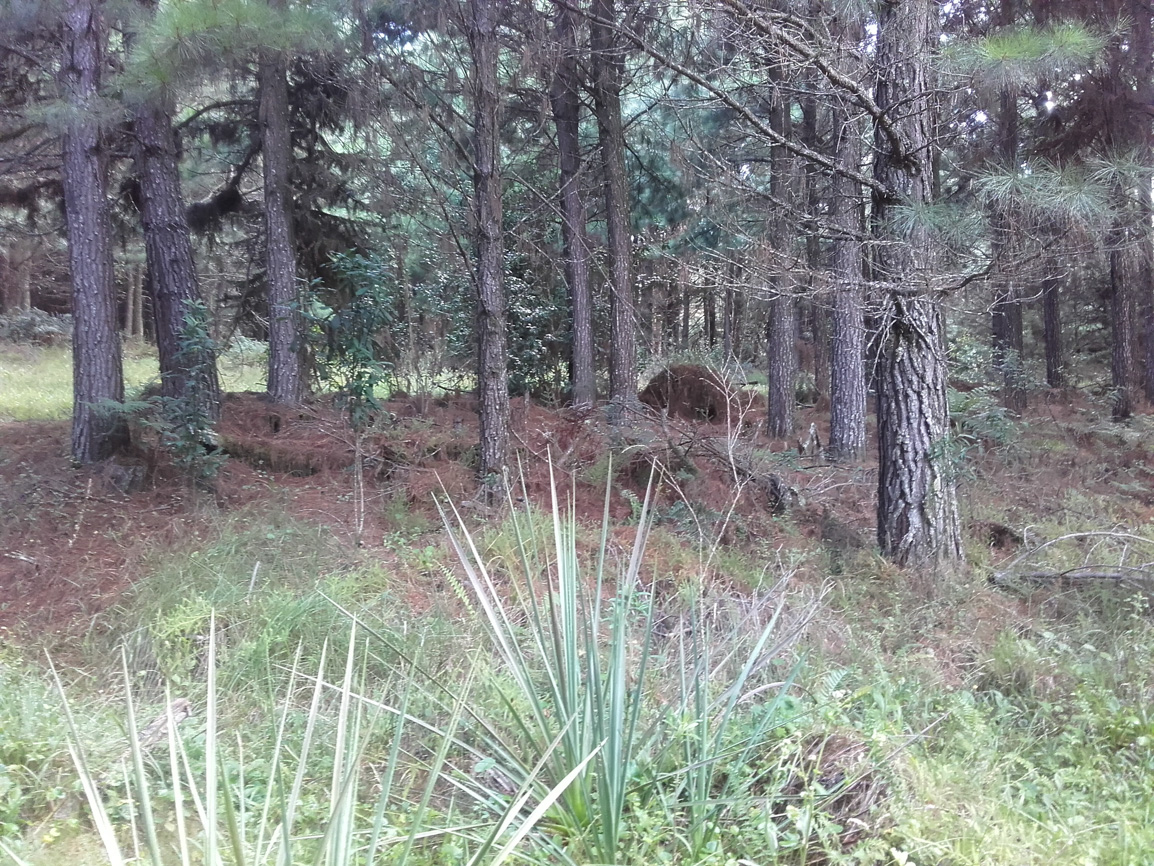

In [28]:
print preds[:5]

filenames = batches.filenames
print filenames[:5]
from PIL import Image
Image.open(path+'test/' + filenames[2])

### vgg16stijn.py

In [8]:
%%writefile vgg16stijn.py

import json
import numpy as np
from keras.utils.data_utils import get_file
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, ZeroPadding2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Dense, Dropout, Flatten, Lambda
from keras.optimizers import Adam #, SGD, RMSprop

vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))
def RGB_to_BGR(x):
    x = x - vgg_mean
    return x[:, ::-1] # reverse axis rgb->bgr
        
class Vgg16Stijn():
    def __init__(self): # sets up neural network
        self.FILE_PATH = 'http://files.fast.ai/models/'
        self.create()
        self.get_classes()
    
    def create(self): # build actual network
        """
            Builds neural network and loads pretrained vgg16 model weights
        """
        model = self.model = Sequential()
        model.add(Lambda(RGB_to_BGR, input_shape=(3,224,224), output_shape=(3,224,224))) #change rgb to bgr
        
        self.add_convlayers(2, 64)
        self.add_convlayers(2, 128)
        self.add_convlayers(3, 256)
        self.add_convlayers(3, 512)
        self.add_convlayers(3, 512)
        
        model.add(Flatten())
        self.add_fullconnect()
        self.add_fullconnect()
        model.add(Dense(1000, activation='softmax'))

        fname = 'vgg16.h5'
        model.load_weights(get_file(fname, self.FILE_PATH+fname, cache_subdir='models'))
    
    def add_convlayers(self, layers, filters):
        """
            Adds a specified number of ZeroPadding (line of zeros around image) and Covolution layers
            to the model, and a MaxPooling (outputs max value of group) layer at the very end.

            Args:
                layers (int):   The number of zero padded convolution layers
                                to be added to the model.
                filters (int):  The number of convolution filters to be 
                                created for each layer. I think these are the 
                                number of learnable features per layer
        """
        model = self.model
        for i in range(layers):
            model.add(ZeroPadding2D((1, 1)))
            model.add(Convolution2D(filters, 3, 3, activation='relu'))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    def add_fullconnect(self):
        """
            Adds a fully connected layer of 4096 neurons (with 64x64 dimension) to the model with a
            Dropout of 0.5. Dropout is random 0.5 of the input nodes are set to 0 to prevent overfitting.

            Args:   None
            Returns:   None
        """
        model = self.model
        model.add(Dense(4096, activation='relu')) # fully connected layer with 64x64 dimension
        model.add(Dropout(0.5)) # random half of the input nodes are set to 0 to prevent overfitting
    
    def get_classes(self):
        fname = 'imagenet_class_index.json'
        fpath = get_file(fname, self.FILE_PATH+fname, cache_subdir='models')
        with open(fpath) as f:
            class_dict = json.load(f)
        self.classes = [class_dict[str(i)][1] for i in range(len(class_dict))]
        
    def batch_iterator(self, path, gen=image.ImageDataGenerator(), shuffle=True, batch_size=8, class_mode='categorical'):
        return gen.flow_from_directory(directory=path, target_size=(224,224),
                    class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

    def change_number_outputnodes(self, num):
        model = self.model
        model.pop()
        for layer in model.layers:
            layer.trainable = False
        model.add(Dense(num,activation='softmax'))
        self.compile()
        
    def compile(self, lr=0.001):
        """
            Configures the model for training.
            See Keras documentation: https://keras.io/models/model/
        """
        self.model.compile(optimizer=Adam(lr=lr),
                loss='categorical_crossentropy', metrics=['accuracy'])
    
    def finetune_to_classes(self, batches):
        """
            Adjusts final layer to correct number of output nodes and updates class labels.
            
            Args:
                batches: keras.preprocessing.image.ImageDataGenerator opbject with flow_from_directory()
        """
        self.change_number_outputnodes(batches.nb_class)
        classes = list(iter(batches.class_indices)) 
        # creates list of classes from dict item 'batches.class_indices'
        # batches.class_indices i.e. {'invasive': 1, 'non_invasive': 0}
        for key in batches.class_indices:
            classes[batches.class_indices[key]] = key
        # orders class keys by value in dict like ['non_invasive', 'invasive'] because key 'non_invasive' has value 0
        self.classes = classes
        
    def fit(self, batches, val_batches, nb_epoch=1):
        """
            Fits the model on data yielded batch-by-batch by a Python generator.
            See Keras documentation: https://keras.io/models/model/
        """
        self.model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=nb_epoch,
                validation_data=val_batches, nb_val_samples=val_batches.nb_sample)
        print('fit done')
    
    def fit_n_save(self, batches, val_batches, nb_epoch, results_path, extra_info=''):
        """
            Uses fit and saves weights every epoch
            
            Args:
                batches, val_batches, nb_epoch
                extra_info: string attached to filename
        """
        extra_info = str(extra_info)
        latest_weights_filename = None
        for epoch in range(nb_epoch):
            print('Epoch %d' %epoch)
            self.fit(batches, val_batches, nb_epoch=1)
            latest_weights_filename = 'ft%d%s.h5' %(epoch+1, extra_info)
            self.model.save_weights(results_path+latest_weights_filename)
        print "Completed %s fit operations" % nb_epoch
    
    def test(self, path, batch_size=8):
        """
            Predicts the classes using the trained model on data yielded batch-by-batch.

            Args:
                path (string):  Path to the target directory. It should contain one subdirectory 
                                per class.
                batch_size (int): The number of images to be considered in each batch.
            
            Returns:
                test_batches, numpy array(s) of predictions for the test_batches.
    
        """
        test_batches = self.batch_iterator(path, shuffle=False, batch_size=batch_size, class_mode=None)
        return test_batches, self.model.predict_generator(test_batches, test_batches.nb_sample)

Overwriting vgg16stijn.py


### vgg16.py

In [ ]:
# %load vgg16.py
from __future__ import division, print_function

import os, json
from glob import glob
import numpy as np
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image

# In case we are going to use the TensorFlow backend we need to explicitly set the Theano image ordering
from keras import backend as K
K.set_image_dim_ordering('th')


vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))
def vgg_preprocess(x):
    """
        Subtracts the mean RGB value, and transposes RGB to BGR.
        The mean RGB was computed on the image set used to train the VGG model.

        Args: 
            x: Image array (height x width x channels)
        Returns:
            Image array (height x width x transposed_channels)
    """
    x = x - vgg_mean
    return x[:, ::-1] # reverse axis rgb->bgr


class Vgg16():
    """
        The VGG 16 Imagenet model
    """


    def __init__(self):
        self.FILE_PATH = 'http://files.fast.ai/models/'
        self.create()
        self.get_classes()


    def get_classes(self):
        """
            Downloads the Imagenet classes index file and loads it to self.classes.
            The file is downloaded only if it not already in the cache.
        """
        fname = 'imagenet_class_index.json'
        fpath = get_file(fname, self.FILE_PATH+fname, cache_subdir='models')
        with open(fpath) as f:
            class_dict = json.load(f)
        self.classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

    def predict(self, imgs, details=False):
        """
            Predict the labels of a set of images using the VGG16 model.

            Args:
                imgs (ndarray)    : An array of N images (size: N x width x height x channels).
                details : ??
            
            Returns:
                preds (np.array) : Highest confidence value of the predictions for each image.
                idxs (np.ndarray): Class index of the predictions with the max confidence.
                classes (list)   : Class labels of the predictions with the max confidence.
        """
        # predict probability of each class for each image
        all_preds = self.model.predict(imgs)
        # for each image get the index of the class with max probability
        idxs = np.argmax(all_preds, axis=1)
        # get the values of the highest probability for each image
        preds = [all_preds[i, idxs[i]] for i in range(len(idxs))]
        # get the label of the class with the highest probability for each image
        classes = [self.classes[idx] for idx in idxs]
        return np.array(preds), idxs, classes


    def ConvBlock(self, layers, filters):
        """
            Adds a specified number of ZeroPadding and Covolution layers
            to the model, and a MaxPooling layer at the very end.

            Args:
                layers (int):   The number of zero padded convolution layers
                                to be added to the model.
                filters (int):  The number of convolution filters to be 
                                created for each layer.
        """
        model = self.model
        for i in range(layers):
            model.add(ZeroPadding2D((1, 1)))
            model.add(Convolution2D(filters, 3, 3, activation='relu'))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))


    def FCBlock(self):
        """
            Adds a fully connected layer of 4096 neurons to the model with a
            Dropout of 0.5

            Args:   None
            Returns:   None
        """
        model = self.model
        model.add(Dense(4096, activation='relu'))
        model.add(Dropout(0.5))


    def create(self):
        """
            Creates the VGG16 network achitecture and loads the pretrained weights.

            Args:   None
            Returns:   None
        """
        model = self.model = Sequential()
        model.add(Lambda(vgg_preprocess, input_shape=(3,224,224), output_shape=(3,224,224)))

        self.ConvBlock(2, 64)
        self.ConvBlock(2, 128)
        self.ConvBlock(3, 256)
        self.ConvBlock(3, 512)
        self.ConvBlock(3, 512)

        model.add(Flatten())
        self.FCBlock()
        self.FCBlock()
        model.add(Dense(1000, activation='softmax'))

        fname = 'vgg16.h5'
        model.load_weights(get_file(fname, self.FILE_PATH+fname, cache_subdir='models'))


    def get_batches(self, path, gen=image.ImageDataGenerator(), shuffle=True, batch_size=8, class_mode='categorical'):
        """
            Takes the path to a directory, and generates batches of augmented/normalized data. Yields batches indefinitely, in an infinite loop.

            See Keras documentation: https://keras.io/preprocessing/image/
        """
        return gen.flow_from_directory(path, target_size=(224,224),
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)


    def ft(self, num):
        """
            Replace the last layer of the model with a Dense (fully connected) layer of num neurons.
            Will also lock the weights of all layers except the new layer so that we only learn
            weights for the last layer in subsequent training.

            Args:
                num (int) : Number of neurons in the Dense layer
            Returns:
                None
        """
        model = self.model
        model.pop()
        for layer in model.layers: layer.trainable=False
        model.add(Dense(num, activation='softmax'))
        self.compile()

    def finetune(self, batches):
        """
            Modifies the original VGG16 network architecture and updates self.classes for new training data.
            
            Args:
                batches : A keras.preprocessing.image.ImageDataGenerator object.
                          See definition for get_batches().
        """
        self.ft(batches.nb_class)
        classes = list(iter(batches.class_indices)) # get a list of all the class labels
        # batches.class_indices is a dict with the class name as key and an index as value
        # eg. {'cats': 0, 'dogs': 1}

        # sort the class labels by index according to batches.class_indices and update model.classes
        for c in batches.class_indices:
            classes[batches.class_indices[c]] = c
        self.classes = classes


    def compile(self, lr=0.001):
        """
            Configures the model for training.
            See Keras documentation: https://keras.io/models/model/
        """
        self.model.compile(optimizer=Adam(lr=lr),
                loss='categorical_crossentropy', metrics=['accuracy'])


    def fit_data(self, trn, labels,  val, val_labels,  nb_epoch=1, batch_size=64):
        """
            Trains the model for a fixed number of epochs (iterations on a dataset).
            See Keras documentation: https://keras.io/models/model/
        """
        self.model.fit(trn, labels, nb_epoch=nb_epoch,
                validation_data=(val, val_labels), batch_size=batch_size)


    def fit(self, batches, val_batches, nb_epoch=1):
        """
            Fits the model on data yielded batch-by-batch by a Python generator.
            See Keras documentation: https://keras.io/models/model/
        """
        self.model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=nb_epoch,
                validation_data=val_batches, nb_val_samples=val_batches.nb_sample)


    def test(self, path, batch_size=8):
        """
            Predicts the classes using the trained model on data yielded batch-by-batch.

            Args:
                path (string):  Path to the target directory. It should contain one subdirectory 
                                per class.
                batch_size (int): The number of images to be considered in each batch.
            
            Returns:
                test_batches, numpy array(s) of predictions for the test_batches.
    
        """
        test_batches = self.get_batches(path, shuffle=False, batch_size=batch_size, class_mode=None)
        return test_batches, self.model.predict_generator(test_batches, test_batches.nb_sample)



### ma code

In [ ]:
path = DATA_HOME_DIR
# path = DATA_HOME_DIR + '/sample/'

In [14]:
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import csv
import math

import utils; reload(utils)
from utils import plots
import vgg16; reload(vgg16)
from vgg16 import Vgg16

batch_size = 8

vgg = Vgg16()
# Grab a few images at a time for training and validation.
# NB: They must be in subdirectories named based on their category
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)
test_batches = vgg.get_batches(path+'temptest', batch_size=batch_size, shuffle=False)
vgg.finetune(batches)
vgg.fit(batches, val_batches, nb_epoch=2)

Found 2111 images belonging to 2 classes.
Found 184 images belonging to 2 classes.
Found 1531 images belonging to 1 classes.
Epoch 1/2
  72/2111 [>.............................] - ETA: 828s - loss: 1.0159 - acc: 0.6528

KeyboardInterrupt: 

In [3]:
def batch_dogness(test_batches):
    imgs,nolabel = next(test_batches)
    preds, idxs, labels = vgg.predict(imgs)
    dogness = np.multiply(preds, idxs) + np.multiply(1.-preds, 1-idxs)
    return dogness

In [10]:
def predict_order_testset(testfolder):
#     files_names = os.listdir(path+testfolder)
    files_names = test_batches.filenames
    files_names = [int(files_names[i][5:-4]) for i in range(len(files_names))]
    N = int(math.ceil(len(files_names)/batch_size))
#     predictions = [x for i in range(N) for x in batch_dogness(test_batches).tolist()]
    predictions = [x for i in range(N) for x in batch_dogness(test_batches).clip(0.01,0.99).tolist()] #Use clipping because of log loss judgement by Kaggle
    predictions_ordered = [x for (y,x) in sorted(zip(files_names,predictions))]
    return predictions_ordered

In [11]:
def write_csv(predictions_ordered):
    with open(path+'test.csv', 'wb') as f:
        fieldnames = ['id', 'label']
        wr = csv.writer(f, delimiter=',')
        wr.writerow(fieldnames)
        for i in range(len(predictions_ordered)):
            wr.writerow([i+1,predictions_ordered[i]])

In [12]:
predictions = predict_order_testset('temptest/test')
write_csv(predictions)

### utils.py

In [ ]:
# %load utils.py
from __future__ import division,print_function
import math, os, json, sys, re
import cPickle as pickle
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
from operator import itemgetter, attrgetter, methodcaller
from collections import OrderedDict
import itertools
from itertools import chain

import pandas as pd
import PIL
from PIL import Image
from numpy.random import random, permutation, randn, normal, uniform, choice
from numpy import newaxis
import scipy
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom
from scipy.ndimage import imread
from sklearn.metrics import confusion_matrix
import bcolz
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE

from IPython.lib.display import FileLink

import theano
from theano import shared, tensor as T
from theano.tensor.nnet import conv2d, nnet
from theano.tensor.signal import pool

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Reshape, merge, LSTM, Bidirectional
from keras.layers import TimeDistributed, Activation, SimpleRNN, GRU
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.regularizers import l2, activity_l2, l1, activity_l1
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils.layer_utils import layer_from_config
from keras.metrics import categorical_crossentropy, categorical_accuracy
from keras.layers.convolutional import *
from keras.preprocessing import image, sequence
from keras.preprocessing.text import Tokenizer

from vgg16 import *
from vgg16bn import *
np.set_printoptions(precision=4, linewidth=100)


to_bw = np.array([0.299, 0.587, 0.114])

def gray(img):
    if K.image_dim_ordering() == 'tf':
        return np.rollaxis(img, 0, 1).dot(to_bw)
    else:
        return np.rollaxis(img, 0, 3).dot(to_bw)

def to_plot(img):
    if K.image_dim_ordering() == 'tf':
        return np.rollaxis(img, 0, 1).astype(np.uint8)
    else:
        return np.rollaxis(img, 0, 3).astype(np.uint8)

def plot(img):
    plt.imshow(to_plot(img))


def floor(x):
    return int(math.floor(x))
def ceil(x):
    return int(math.ceil(x))

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')


def do_clip(arr, mx):
    clipped = np.clip(arr, (1-mx)/1, mx)
    return clipped/clipped.sum(axis=1)[:, np.newaxis]


def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, batch_size=4, class_mode='categorical',
                target_size=(224,224)):
    return gen.flow_from_directory(dirname, target_size=target_size,
            class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)


def onehot(x):
    return to_categorical(x)


def wrap_config(layer):
    return {'class_name': layer.__class__.__name__, 'config': layer.get_config()}


def copy_layer(layer): return layer_from_config(wrap_config(layer))


def copy_layers(layers): return [copy_layer(layer) for layer in layers]


def copy_weights(from_layers, to_layers):
    for from_layer,to_layer in zip(from_layers, to_layers):
        to_layer.set_weights(from_layer.get_weights())


def copy_model(m):
    res = Sequential(copy_layers(m.layers))
    copy_weights(m.layers, res.layers)
    return res


def insert_layer(model, new_layer, index):
    res = Sequential()
    for i,layer in enumerate(model.layers):
        if i==index: res.add(new_layer)
        copied = layer_from_config(wrap_config(layer))
        res.add(copied)
        copied.set_weights(layer.get_weights())
    return res


def adjust_dropout(weights, prev_p, new_p):
    scal = (1-prev_p)/(1-new_p)
    return [o*scal for o in weights]


def get_data(path, target_size=(224,224)):
    batches = get_batches(path, shuffle=False, batch_size=1, class_mode=None, target_size=target_size)
    return np.concatenate([batches.next() for i in range(batches.nb_sample)])


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()


def load_array(fname):
    return bcolz.open(fname)[:]


def mk_size(img, r2c):
    r,c,_ = img.shape
    curr_r2c = r/c
    new_r, new_c = r,c
    if r2c>curr_r2c:
        new_r = floor(c*r2c)
    else:
        new_c = floor(r/r2c)
    arr = np.zeros((new_r, new_c, 3), dtype=np.float32)
    r2=(new_r-r)//2
    c2=(new_c-c)//2
    arr[floor(r2):floor(r2)+r,floor(c2):floor(c2)+c] = img
    return arr


def mk_square(img):
    x,y,_ = img.shape
    maxs = max(img.shape[:2])
    y2=(maxs-y)//2
    x2=(maxs-x)//2
    arr = np.zeros((maxs,maxs,3), dtype=np.float32)
    arr[floor(x2):floor(x2)+x,floor(y2):floor(y2)+y] = img
    return arr


def vgg_ft(out_dim):
    vgg = Vgg16()
    vgg.ft(out_dim)
    model = vgg.model
    return model

def vgg_ft_bn(out_dim):
    vgg = Vgg16BN()
    vgg.ft(out_dim)
    model = vgg.model
    return model


def get_classes(path):
    batches = get_batches(path+'train', shuffle=False, batch_size=1)
    val_batches = get_batches(path+'valid', shuffle=False, batch_size=1)
    test_batches = get_batches(path+'test', shuffle=False, batch_size=1)
    return (val_batches.classes, batches.classes, onehot(val_batches.classes), onehot(batches.classes),
        val_batches.filenames, batches.filenames, test_batches.filenames)


def split_at(model, layer_type):
    layers = model.layers
    layer_idx = [index for index,layer in enumerate(layers)
                 if type(layer) is layer_type][-1]
    return layers[:layer_idx+1], layers[layer_idx+1:]


class MixIterator(object):
    def __init__(self, iters):
        self.iters = iters
        self.multi = type(iters) is list
        if self.multi:
            self.N = sum([it[0].N for it in self.iters])
        else:
            self.N = sum([it.N for it in self.iters])

    def reset(self):
        for it in self.iters: it.reset()

    def __iter__(self):
        return self

    def next(self, *args, **kwargs):
        if self.multi:
            nexts = [[next(it) for it in o] for o in self.iters]
            n0 = np.concatenate([n[0] for n in nexts])
            n1 = np.concatenate([n[1] for n in nexts])
            return (n0, n1)
        else:
            nexts = [next(it) for it in self.iters]
            n0 = np.concatenate([n[0] for n in nexts])
            n1 = np.concatenate([n[1] for n in nexts])
            return (n0, n1)

